# Rebalancing a portfolio (Fixed Weights, By Time Period)

Going on with the topic of passive investing and analyses with python, the objective of this code is to compute the historical performance of a porfolio with a given assets, weights and frequency to rebalance.

### Importing the libraries and defining the Portfolio

In [89]:
import yfinance as yf
import pandas as pd
import numpy as np

# Dictionary with the asset classes and the chosen etfs to represent them in our portfolio
securities = {
    'US_Stocks' : ['IVV', 0.5],
    'Bonds' : ['AGG', 0.3],
    'TIPs' : ['TIP', 0.2],
}

### Defining the main function

Here we have the function that will calculate the historical performance of the portfolio, and it has two functions to auxiliate itself. 

In [93]:
def backtesting(securities, freq = "M"):
    '''
    Based in chosen securities with respectives weights and a frequency to rebalance
    we compute the historical performance of a portfolio
    '''
    def getSecurityData(portfolio):
        '''
        The function gets a dictionary as input and calculates the historical return of the securities chosen
        '''
        basket_returns = []

        for asset in portfolio.items():
            security = yf.Ticker(asset[1][0]).history(period="max")
            returns = security['Close'].pct_change().dropna()
            weight = asset[1][1]
            basket_returns.append(returns)

        hist_returns = pd.concat(basket_returns, 1)
        hist_returns = hist_returns.dropna()
        hist_returns.columns = portfolio.keys()

        return hist_returns
    
    def creatingIndex(dates, frequency = 'm'):
        '''
        It creates a list with booleans indicating when to rebalance
        '''
        last_month = None
        index = []
        for i in dates.index:
            month = str(i.to_period(frequency))
            if month != last_month:
                index.append(True)
            else: 
                index.append(False)
            last_month = month

        return index
    
    data = getSecurityData(securities)
    index = creatingIndex(data, freq)
    weights = np.array([securities[i][1] for i in securities])
    tot_assets = 1000
    
    historic = []
    data = getSecurityData(securities)
    prev_assets = tot_assets * weights
    
    for i in range(data.shape[0]):
        ind_return = (data.iloc[i]+1)
        if index[i]:
            tot_assets = prev_assets.sum()
            prev_assets = tot_assets * weights * ind_return
        else:
            prev_assets = prev_assets * ind_return
        historic.append(prev_assets)
    
    port = pd.DataFrame(historic, index = data.index, columns = data.columns).sum(axis = 1)
    
    return port

### Calling the function

We call the function asking for rebalance every quarter and plot to see how it worked

<ipython-input-112-6292b20f201a>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  yaxis = plot.set_yticklabels(['{:,.2%}'.format(x) for x in vals])


<AxesSubplot:title={'center':'Quarterly Rebalance Portfolio'}, xlabel='Date'>

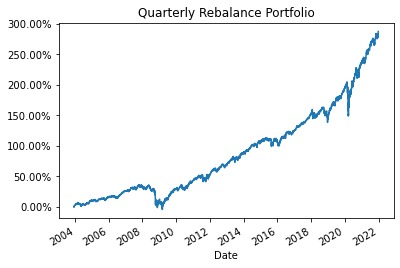

In [112]:
returns = backtesting(securities, 'q').pct_change()
ind_returns = (returns+1).cumprod()-1
plot = ind_returns.plot(title = "Quarterly Rebalance Portfolio")
vals = plot.get_yticks()
yaxis = plot.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plot